# GHP Construction with Duration Matching

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [3]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [5]:
erk.bond_price(20, 1000, 0.05, 2, .04)

1136.7773962036904

In [6]:
erk.bond_price(20, 1000, 0.03, 2, .04)

863.2226037963086

In [7]:
erk.bond_price(20, 1000, 0.04, 2, .04)

999.9999999999995

In [9]:
rates = np.linspace(0.01, 0.1, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [11]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates] # List comprehension
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

<AxesSubplot:title={'center':'Price of 10Y bond with different interest rates'}>

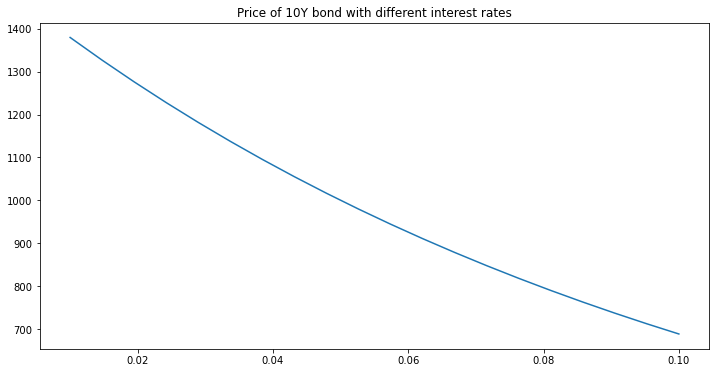

In [16]:
pd.DataFrame(data=prices, index=rates).plot(title='Price of 10Y bond with different interest rates',
                                            legend=False,
                                            figsize=(12,6)
                                           )

In [18]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [20]:
discounts = erk.discount(cf.index, .06/2)
discounts
# These are the discount factors

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [22]:
dcf = discounts*cf
dcf
# Present value of each cash flow

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [24]:
weights = dcf/dcf.sum()
weights
# Set of weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [28]:
# We will weight each period by those weights
weighted_average_periods = (cf.index*weights).sum()
weighted_average_periods
# Weighted average duration (Macaulay Duration)

5.579707187194534

This is directly related to the rate of change, the first derivative of the price relative to interest rates.

If interest moves with a large duration, then the price will change a lot.

In [29]:
erk.macaulay_duration(cf, 0.06/2)

5.579707187194534

You want to match the duration of your liabilities with the duration of your bonds. Works only when the yield curve shifts parrallely.

Need to fix those yield curve factors.

## Duration Matching

In [32]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12]) # Due in 10Y and 12Y
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [33]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04) # Maturity 10Y
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04) # Maturity 20Y
md_10, md_20

(8.190898824083233, 13.544718122145921)

We need to find which fraction of these two bonds we neek to have to match the liability duration.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$w_s*8.19+(1-w_s)*13.54=10.96$$

more generally:

$$w_s*d_s+(1-w_s)*d_l=d_t$$

rearranging gives:

$$w_s=\frac{d_l-d_t}{d_l-d_s}$$

In [48]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s, short_bond
# This is the weight I need to put in the short bond.

(0.48263092069478974,
 1       50.0
 2       50.0
 3       50.0
 4       50.0
 5       50.0
 6       50.0
 7       50.0
 8       50.0
 9       50.0
 10    1050.0
 dtype: float64)

In [61]:
price_short = erk.bond_price(10, 1000, 0.05, 1, .04)
price_long = erk.bond_price(20, 1000, 0.05, 1, .04)
assets_0 = 130000
# What do I need in order to compute the Macaulay Duration of this portfolio?
pf_flows = pd.concat([assets_0*w_s*short_bond/price_short,assets_0*(1-w_s)*long_bond/price_long])
erk.macaulay_duration(pf_flows, .04), price_short

(10.960799385088393, 1081.10895779355)

In [59]:
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [60]:
cfr = erk.funding_ratio(pf_flows, liabilities, 0.04)
cfr

0.9998760012192478

<AxesSubplot:title={'center':'Funding Ratios with changes in Interest Rates'}>

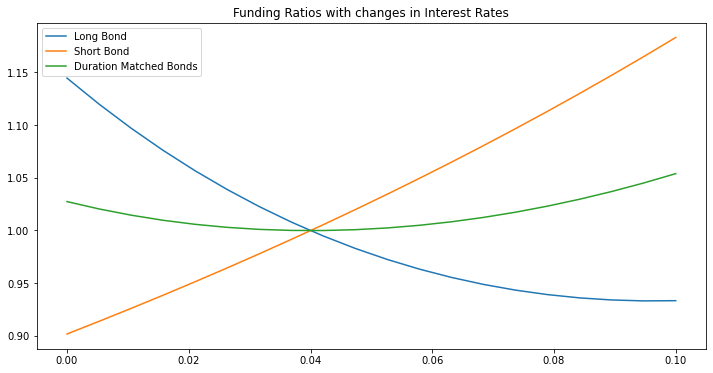

In [47]:
rates = np.linspace(0, .1, 20)

lb_assets = assets_0*long_bond/price_long
sb_assets = assets_0*short_bond/price_short

fr_change = pd.DataFrame({
    'Long Bond': [erk.funding_ratio(lb_assets, liabilities, r) for r in rates], #100% on long bonds
    'Short Bond': [erk.funding_ratio(sb_assets, liabilities, r) for r in rates], #100% on short bonds
    'Duration Matched Bonds': [erk.funding_ratio(pf_flows, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Funding Ratios with changes in Interest Rates', figsize=(12,6))

No more interest risk ! (for parallel shifts of the yield curve)